# Recommendation system aproches

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Wide and Deep learning With TensorFlow in 10 Min](https://medium.com/@rinu.gour123/wide-and-deep-learning-with-tensorflow-in-10-min-4eb897dbcaf6)
* [wide_and_deep_keras](https://github.com/jrzaurin/Wide-and-Deep-Keras/blob/master/wide_and_deep_keras.py)
* [Wide_&_Deep_Features_Columns+Auto_ML](https://github.com/adrianmarino/wide-and-deep-example/blob/master/Wide_%26_Deep_Features_Columns%2BAuto_ML.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./src')

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from callback import MetricsPlotter
from util import tf_detected_devices, tf_version, plot_model, dataframe_to_dataset

from model import   EmbeddingDenseModelFactory, \
                    EmbeddingBiasesDotModelFactory, \
                    EmbeddingDotModelFactory, \
                    ModelInputBuilder, Layer, \
                    WideAndDeepModelFactory

from data import    InMemoryXyDataGenerator, \
                    DataSetDataGenerator, \
                    MovieLensDataSource

# from kerastuner import HyperModel
# from kerastuner.tuners import RandomSearch, Hyperband
# from kerastuner.engine.hyperparameters import HyperParameters

### Check environment

Show GPU model:

In [3]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce GTX 1060, 6078 MiB


Let's check tensorflow version:

In [4]:
tf_version()

'Tensorflow version: 2.3.0'

Let's check devices that tensorflow detect:

In [5]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:XLA_CPU:0,XLA_CPU,16G,device: XLA_CPU device
2,/device:XLA_GPU:0,XLA_GPU,16G,device: XLA_GPU device


[What is XLA?](https://medium.com/@xianbao.qian/use-xla-with-keras-3ca5d0309c26)

### Download dataset

Create a data source to download and read dataset files:

In [6]:
ds = MovieLensDataSource()

Available files:

In [7]:
print(ds.files())

['ratings.csv', 'links.csv', 'movies.csv', 'tags.csv']


Rating that users give to each movie:

In [8]:
ratings = ds.get_df('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Movie catalog: Each movie has a tittle and a list of genres.

In [9]:
movies = ds.get_df('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Tags that users put to movies: Each line of this file after the header row represents one tag applied to one movie by one user.

In [10]:
tags = ds.get_df('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**Links** file contains one row by movie and eack column represent the movie id for each movie site:

* **movieId**: is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

* **imdbId**: is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

* **tmdbId**: is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>

**Note**: It will we usefull when we test each model.

In [11]:
links = ds.get_df('links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Analize and prepare the required data

First, get 15 users with highest total ratings sum: 

In [12]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

top_users.to_frame().head()

,rating
userId,
414,2698
599,2478
474,2108
448,1864
274,1346


Get 15 moviles with highest total ratings sum:

In [13]:
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_movies.to_frame().head()

,rating
movieId,
356,329
318,317
296,307
593,279
2571,278


Build next table only with top users and movies ([Because use inner join](https://www.datacamp.com/community/tutorials/joining-dataframes-pandas?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-438999696719:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9041032&gclid=Cj0KCQjwhIP6BRCMARIsALu9LfkDhKFrq-wuEKjjsNxhSBa-315ZxQKIfKV633ynuWrZnqX-jCh7ZMcaArPmEALw_wcB)):

In [14]:
top_r = ratings.join(top_users, rsuffix='_top_user', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_top_movie', how='inner', on='movieId')
top_r = top_r[['userId','movieId', 'rating']]
top_r.head()

,userId,movieId,rating
10360,68,1,2.5
26092,182,1,4.0
36374,249,1,4.0
39229,274,1,4.0
42114,288,1,4.5


Show users vs. movies ratings: It can appresciated that some user did not give a rating to some movies (NaN).

In [15]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


Transform categorical columns values to values from 0 to N-1:

In [16]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

In [17]:
ratings.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


Users and movies count:

In [18]:
n_users, n_movies

(610, 9724)

Min and max rating:

In [19]:
min_rating, max_rating

(0.5, 5.0)

Build X and y sets (Equivalent to features and label for ech training test).

In [20]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

Show features an label for first sample:

In [21]:
X[0], y[0]

(array([0, 0]), 4.0)

Split data to train, validation and test sets:

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1) # , random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((90752, 2), (10084, 2), (90752,), (10084,))

## Model bases colaborative filtering

### Dot product of user and movies embeddings

In [23]:
model1 = EmbeddingDotModelFactory.create(
    n_users, 
    n_movies, 
    n_factors=50,
    lr=0.001,
    l2_delta=1e-6,
    loss='mean_squared_error'
)

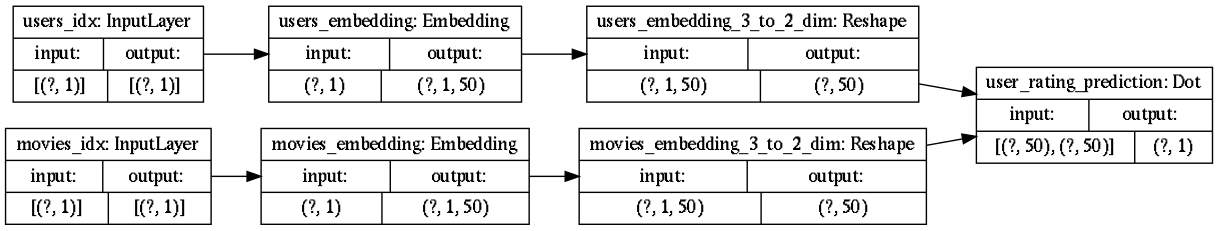

In [24]:
plot_model(model1)

**Note**: Dot product layer perform an element-wise operation. i.e.: [[1..50]. [1..50]] (2,50) x [[50], [50]] (2,50) => [1..50]x[1..50] = [a], [1..50]x[1..50]= [b] => Result: [[a],[b]] (2,1).

In [25]:
 model1.summary()

Model: "Embedding_Dot_Product_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 50)        30500       users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 50)        486200      movies_idx[0][0]                 
________________________________________________________________________

In [26]:
batch_size=64

def to_input(X, y): return [X[:, 0], X[:, 1]], y

training_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    batch_size, 
    shuffle=True, 
    to_input=to_input
)

validation_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val, 
    batch_size, 
    to_input=to_input
)

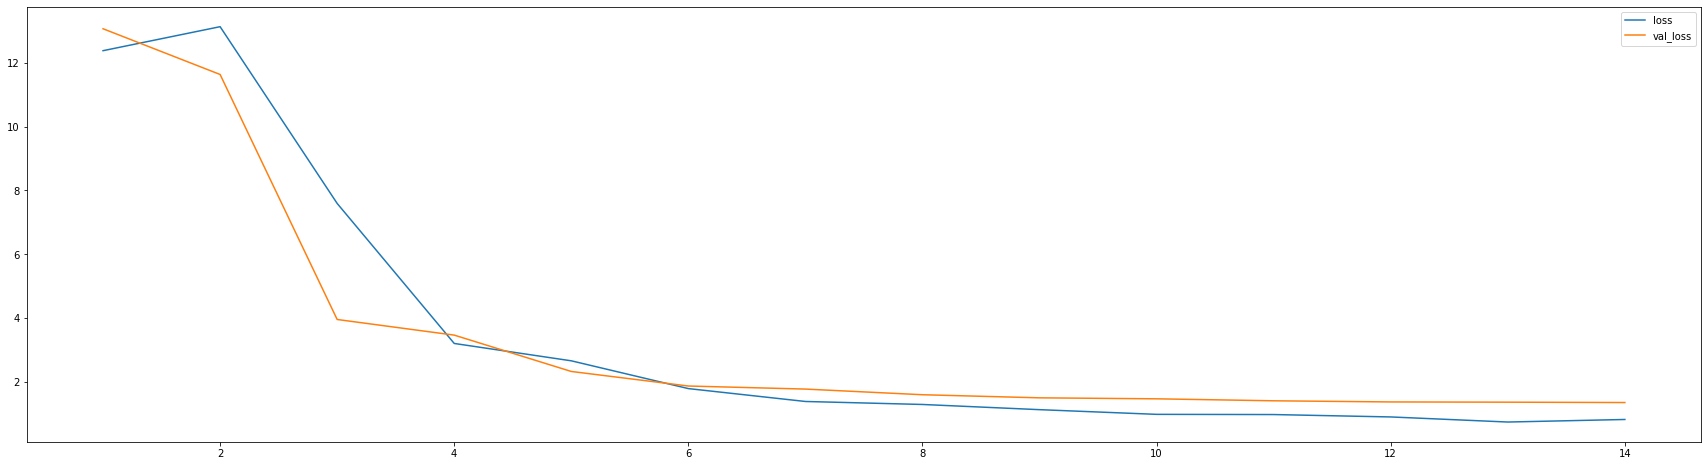

1196/1418 [========================>.....] - ETA: 1s - loss: 0.7871

Evaluate model (Each 600 steps):
157/157 [==============================] - 0s 2ms/step - loss: 1.3415

Validation:
  - Loss (15): 1.341508 (⟱ 0.01637256)

Continue model train:
1418/1418 [==============================] - 8s 5ms/step - loss: 0.9199 - val_loss: 1.3391


In [27]:
history = model1.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1, 
    callbacks=[
        MetricsPlotter(
            validation_generator=validation_generator, 
            metrics_names=['loss'],
            plot_interval=500,
            evaluate_interval=600,
            batch_size=batch_size
        )
    ]
)

In [28]:
def evaluate_xy_model(model, X, y, batch_size):
    data_generator = InMemoryXyDataGenerator(X, y, len(X_val), to_input=to_input)
    X_t, y_t = data_generator[0]
    print(X_t[0].shape)
    return model.evaluate(X_t, y_t, batch_size=batch_size, verbose=0)

### Dot product of users and movies embedding + Biases

In [29]:
model2 = EmbeddingBiasesDotModelFactory.create(
    n_users, 
    n_movies, 
    n_factors=50,
    min_rating=min_rating, 
    max_rating=max_rating,
    lr=0.001,
    loss='mean_squared_error'
)

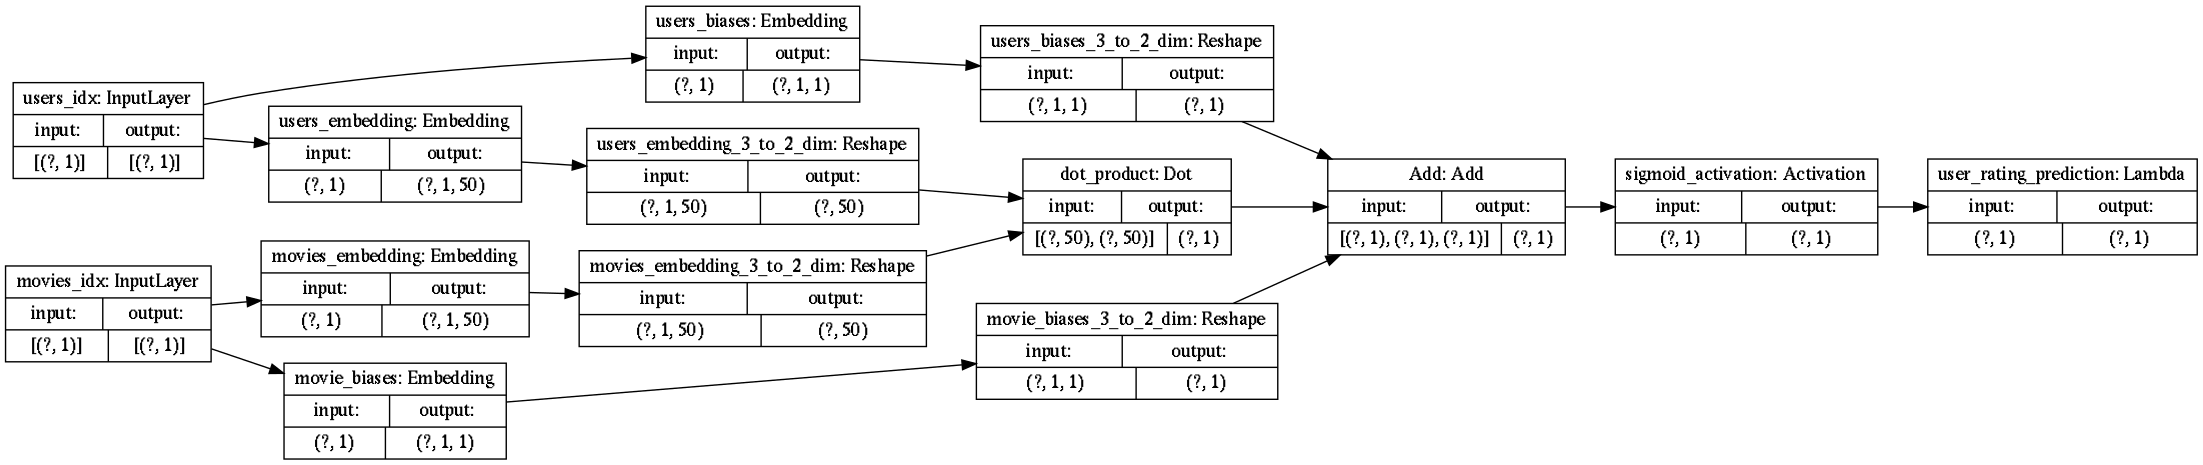

In [30]:
plot_model(model2)

In [31]:
model2.summary()

Model: "Embedding_Dot_Product_Plus_Biases_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 50)        30500       users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 50)        486200      movies_idx[0][0]                 
____________________________________________________________

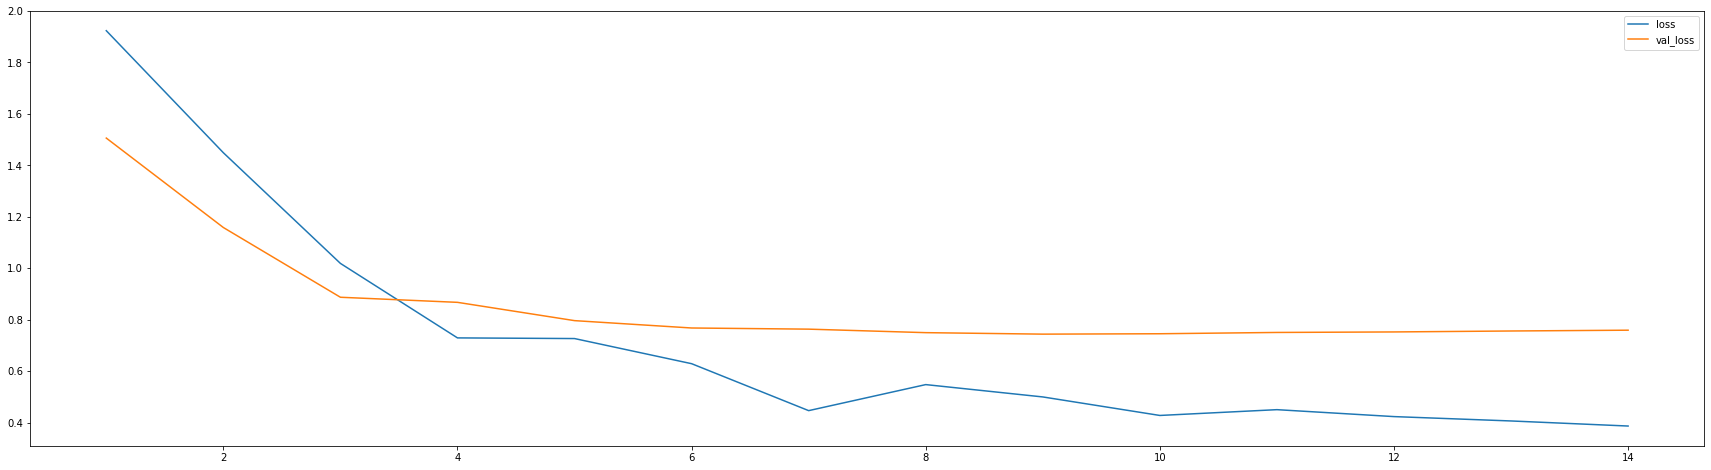

1198/1418 [========================>.....] - ETA: 1s - loss: 0.3677

Evaluate model (Each 600 steps):
157/157 [==============================] - 0s 2ms/step - loss: 0.7661

Validation:
  - Loss (15): 0.766087 (⟰ 0.00676978)

Continue model train:
1418/1418 [==============================] - 8s 6ms/step - loss: 0.4640 - val_loss: 0.7692


In [32]:
history = model2.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1, 
    callbacks=[
        MetricsPlotter(
            validation_generator=validation_generator, 
            metrics_names=['loss'],
            plot_interval=500,
            evaluate_interval=600,
            batch_size=batch_size
        )
    ]
)

In [33]:
batch_size

64

In [34]:
X_val.shape

(10084, 2)

In [35]:
evaluate_xy_model(model2, X_val, y_val, batch_size)

(10084,)


0.7687765955924988

### Deep Model: User and Movie embeddings + Dense layers 

In [36]:
model3 = EmbeddingDenseModelFactory.create(
    n_users, 
    n_movies, 
    n_factors=100,
    min_rating=min_rating, 
    max_rating=max_rating
)

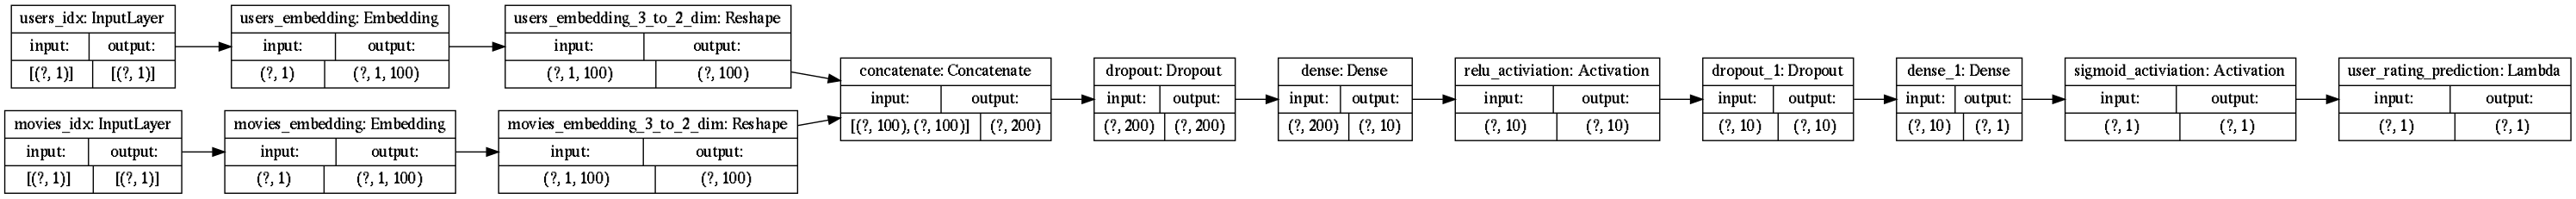

In [37]:
plot_model(model3)

In [38]:
model3.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 100)       61000       users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 100)       972400      movies_idx[0][0]                 
____________________________________________________

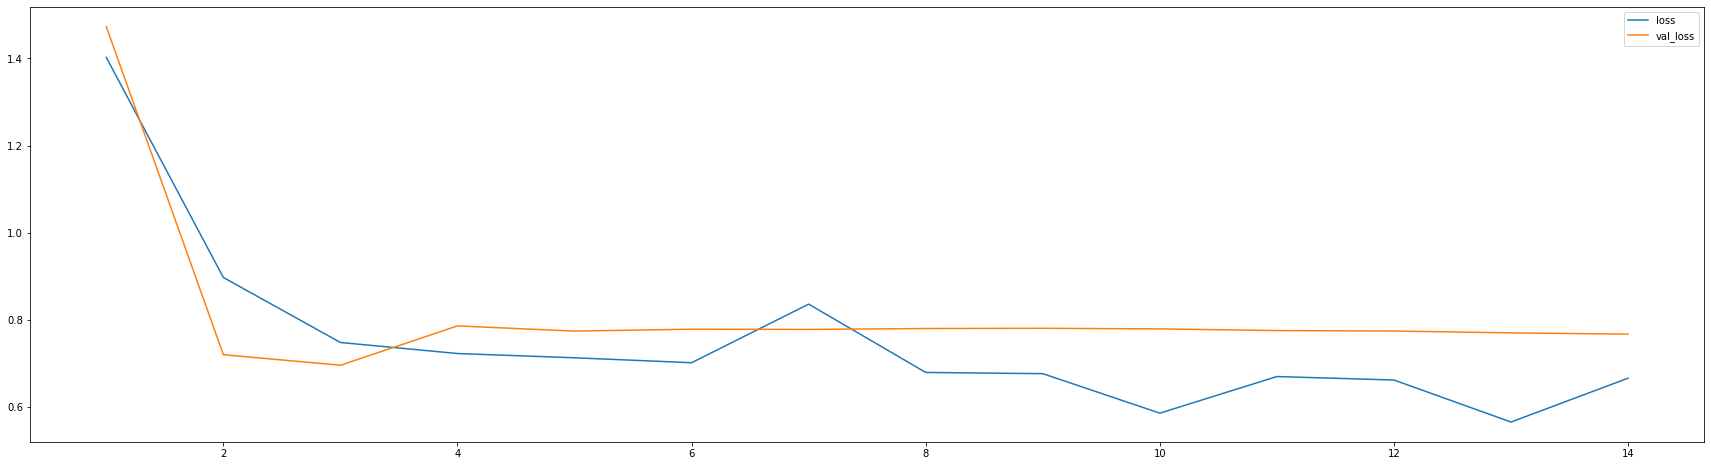

1197/1418 [========================>.....] - ETA: 1s - loss: 0.6487

Evaluate model (Each 600 steps):
157/157 [==============================] - 0s 2ms/step - loss: 0.7740

Validation:
  - Loss (15): 0.773975 (⟰ 0.00687087)

Continue model train:
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6897 - val_loss: 0.7776


In [39]:
history = model3.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1, 
    callbacks=[
        MetricsPlotter(
            validation_generator=validation_generator, 
            metrics_names=['loss'],
            plot_interval=500,
            evaluate_interval=600,
            batch_size=batch_size
        )
    ]
)

In [40]:
history.history['val_loss'][-1]

0.7775930166244507

In [41]:
evaluate_xy_model(model3, X_val, y_val, batch_size)

(10084,)


0.7769647836685181

In [42]:
model3.save_weights('./embedding_feature_layers_plus_dense_layer_model_weights.h5')

### Wide & Deep Model

In [43]:
dataset = pd.DataFrame()
dataset['user'] = ratings['user']
dataset['movie'] = ratings['movie']

dataset['user1'] = ratings['user'].astype('string')
dataset['movie1'] = ratings['movie'].astype('string')

dataset['user2'] = dataset['user'].astype('string')
dataset['movie2'] = dataset['movie'].astype('string')
dataset['rating'] = ratings['rating']

dataset.head()

,user,movie,user1,movie1,user2,movie2,rating
0,0,0,0,0,0,0,4.0
1,0,2,0,2,0,2,4.0
2,0,5,0,5,0,5,4.0
3,0,43,0,43,0,43,5.0
4,0,46,0,46,0,46,5.0


In [44]:
dataset.dtypes

user        int64
movie       int64
user1      string
movie1     string
user2      string
movie2     string
rating    float32
dtype: object

In [45]:
users_num  = dataset['user'].unique()
movies_num = dataset['movie'].unique()

users_str  = dataset['user2'].unique()
movies_str = dataset['movie2'].unique()

In [46]:
len(users_num), len(movies_num)

(610, 9724)

In [47]:
last_user_id = int(users_num[-1])+1
last_movie_id = int(movies_num[-1])+1

In [48]:
print(f'User ids: from 0 to {last_user_id} - Movie ids: from 0 to {last_movie_id}.')

User ids: from 0 to 610 - Movie ids: from 0 to 9373.


In [49]:
wide_inputs = ModelInputBuilder()
user_id_cat = wide_inputs.cat_id("user", ids_count=len(users_num)+1, unknown_value=last_user_id)
movie_id_cat = wide_inputs.cat_id("movie", ids_count=len(movies_num)+1, unknown_value=last_movie_id)

user1_cat  = wide_inputs.cat_one_hot("user1", users_str)
movie1_cat = wide_inputs.cat_one_hot("movie1", movies_str)
wide_inputs.cat_one_hot_crossed(columns=[user1_cat,  movie1_cat], hash_bucket_size=int(1000))

deep_inputs = ModelInputBuilder()
deep_inputs.cat_embedding("user2", users_str, dimension=50)
deep_inputs.cat_embedding("movie2", movies_str, dimension=50)

None

In [50]:
model4 = WideAndDeepModelFactory.create(
    wide_inputs, 
    deep_inputs,
    deep_hidden_layers=[
        Layer(units=800, act='relu', dropout=0.2)
    ],
    max_rating=max_rating, 
    min_rating=min_rating,
    lr=0.001
)

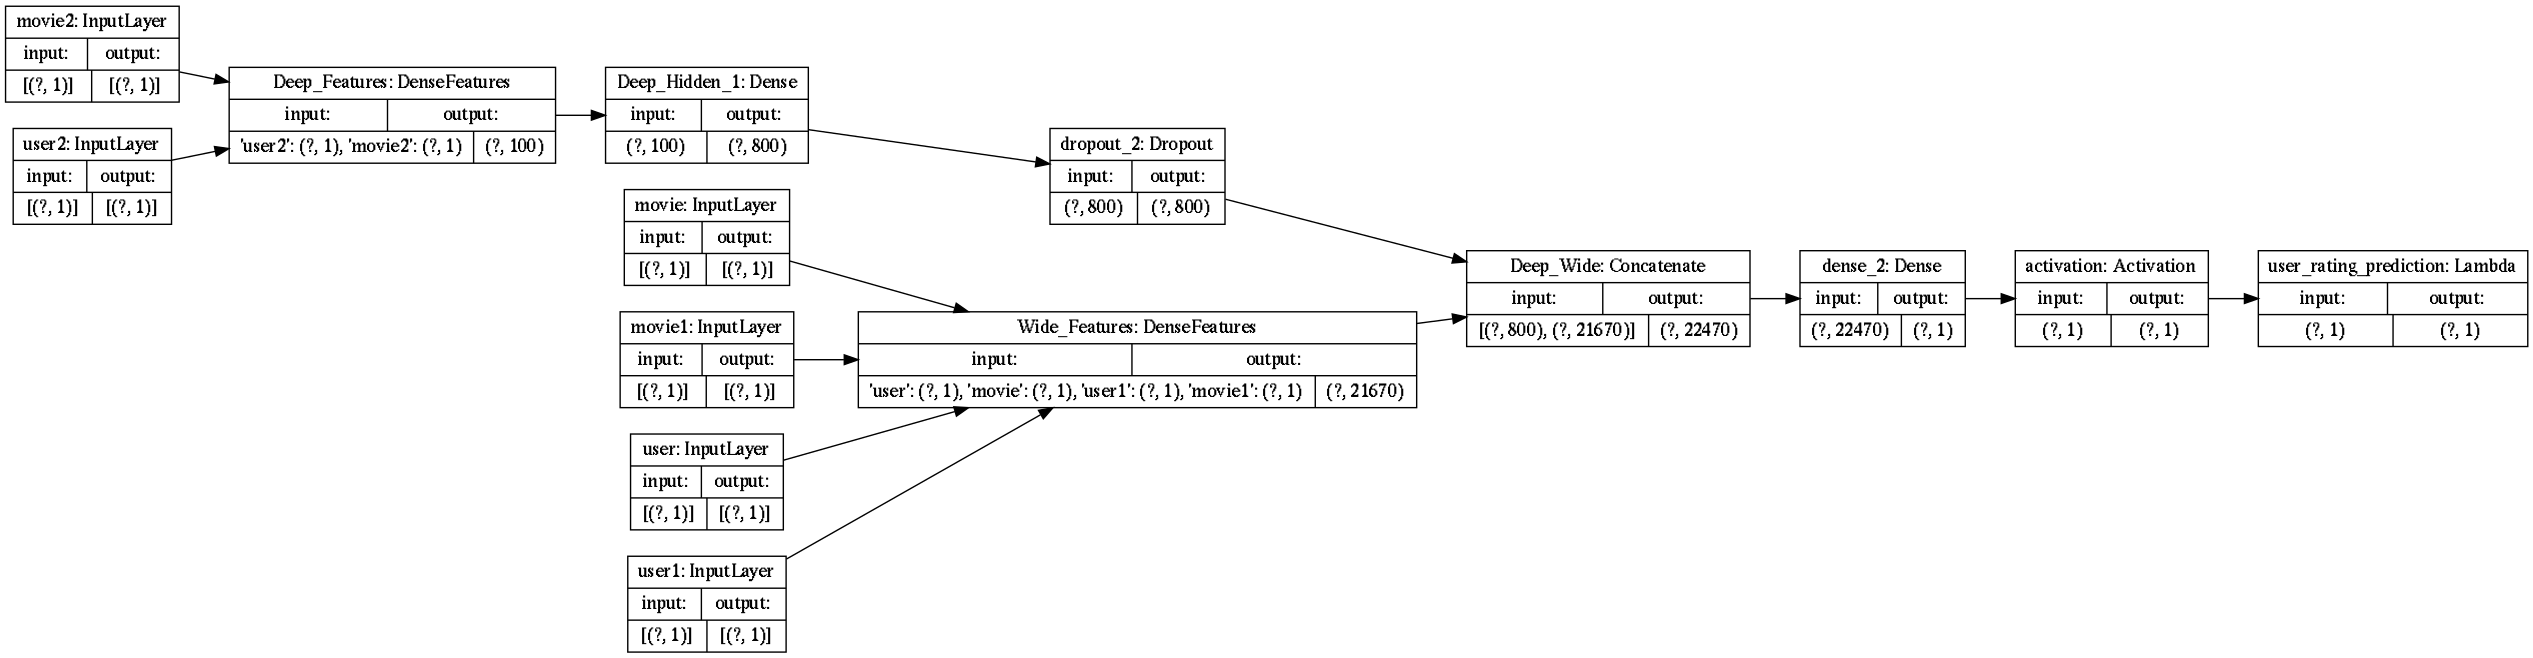

In [51]:
plot_model(model4)

In [52]:
df_train, df_val = train_test_split(dataset, test_size=0.1)

print(len(df_train), 'train examples')
print(len(df_val), 'validation examples')

90752 train examples
10084 validation examples


In [53]:
train_ds = dataframe_to_dataset(df_train,  label='rating',  shuffle=True, batch_size=batch_size)
val_ds = dataframe_to_dataset(df_val, label='rating', batch_size=batch_size)

In [54]:
def show_data(label, dataset, batch_size, dataframe):
    batches = dataset.cardinality().numpy()
    print(f'{label} - Batches(size: {batch_size}): {batches}, Samples: {len(dataframe)}')

In [55]:
show_data('Train', train_ds, batch_size, df_train)
show_data('Validation', val_ds, batch_size, df_val)

Train - Batches(size: 64): 1418, Samples: 90752
Validation - Batches(size: 64): 158, Samples: 10084


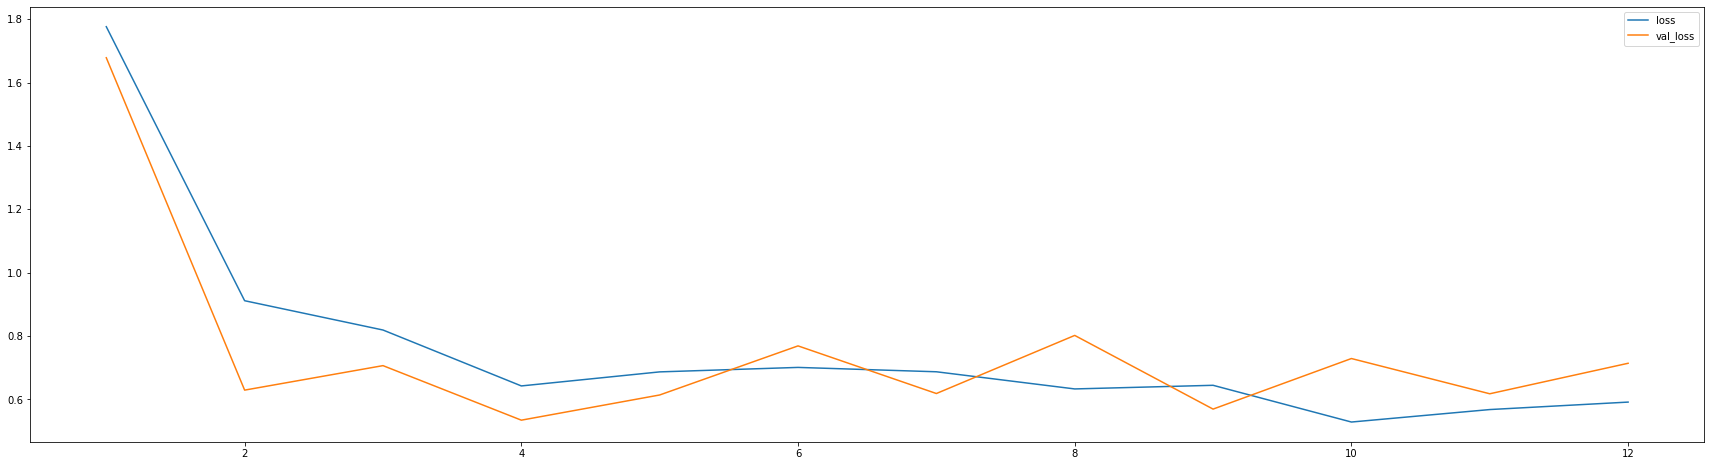

1418/1418 [==============================] - 12s 9ms/step - loss: 0.6066


In [56]:
model4.fit(
    train_ds, 
    batch_size=batch_size,
    epochs=4,
    verbose=1,
    callbacks=[
         MetricsPlotter(
             validation_generator=DataSetDataGenerator(val_ds), 
             metrics_names=['loss'],
             plot_interval=400,
             evaluate_interval=500,
             batch_size=batch_size
         )
    ]
)

In [57]:
model4.evaluate(val_ds, batch_size=val_ds.cardinality().numpy())

158/158 [==============================] - 1s 5ms/step - loss: 0.7595


0.7595293521881104

### Wide and Deep with DNNLinearCombinedRegressor

In [58]:
wide_inputs = ModelInputBuilder()
user_id_cat = wide_inputs.cat_id("user", ids_count=len(users_num)+1, unknown_value=last_user_id)
movie_id_cat = wide_inputs.cat_id("movie", ids_count=len(movies_num)+1, unknown_value=last_movie_id)

user1_cat  = wide_inputs.cat_one_hot("user1", users_str)
movie1_cat = wide_inputs.cat_one_hot("movie1", movies_str)
wide_inputs.cat_one_hot_crossed(columns=[user1_cat,  movie1_cat], hash_bucket_size=int(1000))

deep_inputs = ModelInputBuilder()
deep_inputs.cat_embedding("user2", users_str, dimension=50)
deep_inputs.cat_embedding("movie2", movies_str, dimension=50)

None

In [59]:
from tensorflow.estimator import DNNLinearCombinedRegressor
from tensorflow.compat.v1.train import ProximalAdagradOptimizer, exponential_decay, get_global_step
from tensorflow.keras.optimizers import Adam
import tempfile

In [60]:
# To apply learning rate decay, you can set dnn_optimizer to a callable:
optimizer = lambda: Adam(
        learning_rate=exponential_decay(
        learning_rate=0.001,
        global_step=get_global_step(),
        decay_steps=1000,
        decay_rate=0.96
    )
)

model5 = DNNLinearCombinedRegressor(
    model_dir="model",
    linear_feature_columns=wide_inputs.feature_columns(),
    dnn_feature_columns=deep_inputs.feature_columns(),
    dnn_hidden_units=[1500],
    dnn_optimizer=optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [61]:
# Input builders
def input_fn_train():
    # Returns tf.data.Dataset of (x, y) tuple where y represents label's class
    # index.
    return dataframe_to_dataset(df_train,  label='rating',  shuffle=True, batch_size=1)

def input_fn_eval():
    # Returns tf.data.Dataset of (x, y) tuple where y represents label's class
    # index.
    return dataframe_to_dataset(df_val, label='rating', batch_size=1)

In [62]:
epochs = 100_000

In [ ]:
model5.train(
    input_fn=input_fn_train,
    steps=epochs
)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-90752
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90752...
INFO:tensorflow:Saving checkpoints for 90752 into model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90752...
INFO:tensorflow:loss = 0.1199431, step = 90752
INFO:tensorflo

In [ ]:
metrics = model5.evaluate(input_fn=input_fn_eval, steps=epochs)
metrics

## pytorch wide & deep model

https://github.com/jrzaurin/pytorch-widedeep